In [1]:
%load_ext autoreload
%autoreload 2

import sys
nsd_edf_path = '../../nsd_edf/'
sys.path.append(nsd_edf_path)
sys.path.append('../../nsd/AGAMA/')
import agama
import emcee

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import vaex

agama.setUnits(length=1, velocity=1, mass=1e10)   # 1 kpc, 1 km/s, 1e10 Msun

import sormani_potential

# Load Fritz+VVV data and the properties of the fields
from data import load_fritz_data
data, fields = load_fritz_data(remove_missing_pm=False)

# Create the combined Sormani+22 and Axisymmetric Portail+ potential
sPot = agama.Potential(agama.Potential(nsd_edf_path + 'sormani_2021_potential.agama'), 
                       agama.Potential(nsd_edf_path + 'portail_2017_noCNC_axi.agama'))

# The initial potential used for the iterations of the original Sormani+22 model
init_potential = agama.Potential(nsd_edf_path + 'sormani_2021_initial_potential.agama')

# Build AGAMA galaxy model
sDF = sormani_potential.sormani_DF(init_potential)
sGM = agama.GalaxyModel(sPot,sDF)

## Some assumptions
gc_dist = 8.275 # GC distance
sspread_gl=0.2  # Width of distance sampling distribution 
vscale=200.     # Width of velocity sampling distribution for denominator
vspread=vscale*np.ones(3)
vmeans=np.array([-250.,0.,0.]) # means of velocity sampling distribution

## Small shifts required to transform between (l,b) and the system where SgrA* is at centre
shift_sgrA = np.deg2rad(np.array([0., -0.05576432, -0.04616002]))*8.275

2702 stars in selection


In [144]:
from portail import Portail_fields
pFields = Portail_fields(fields, shift_sgrA, gc_dist, action_finder=None, include_vlos=False)

reading Portail bar...
Omegap=37.5 km/s/kpc


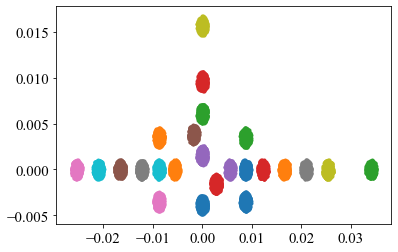

In [188]:
[plt.plot(pFields.fields[f]['coords'][:,0]-shift_sgrA[1]/8.275,pFields.fields[f]['coords'][:,1]-shift_sgrA[2]/8.275,'.')
for f in pFields.fields];

In [189]:
from kde import KDE_fft_ND
from scipy.interpolate import RegularGridInterpolator

class Portail_interp(object):

    def __init__(self, lrange = [-0.03,0.03], brange = 0.02, N=10, radius=0.001, include_vlos=False):
        
        self.lshift = shift_sgrA[1]/gc_dist
        self.bshift = shift_sgrA[2]/gc_dist

        self.lrange, self.brange = np.linspace(lrange[0], lrange[1], N), np.linspace(0., brange, N)
        self.lbgrid = np.meshgrid(self.lrange, self.brange, indexing='ij')

        fltr_fn = lambda ll,bb: np.hypot((pFields.lbr[:,0]-self.lshift-ll)*np.cos(bb),
                                          pFields.lbr[:,1]-self.bshift-bb)<radius
        
        # print([[ll+self.lshift,bb+self.bshift,np.count_nonzero(fltr_fn(ll,bb))]
        #                        for ll,bb in zip(self.lbgrid[0].flatten(),self.lbgrid[1].flatten())])

        self.pft = [KDE_fft_ND(pFields.lbr[fltr_fn(ll,bb),3:5+include_vlos], 
                               weights=pFields.m[fltr_fn(ll,bb)])
                               for ll,bb in zip(self.lbgrid[0].flatten(),self.lbgrid[1].flatten())]

    def evaluate(self, ll, bb, vv):
        return RegularGridInterpolator([self.lrange,self.brange], 
                                        np.reshape([self.pft[i](vv) for i in range(len(self.pft))], lbgrid[0].shape), 
                                        bounds_error=False, fill_value=0.)
# fld_no=15
# print(pFields.fields[fld_no]['centre_l'],pFields.fields[fld_no]['centre_b'],len(pFields.fields[fld_no]['coords']))
# pp = Portail_interp(lrange = [-np.abs(pFields.fields[fld_no]['centre_l']-pp.lshift),np.abs(pFields.fields[fld_no]['centre_l']-pp.lshift)], 
#                     brange =  np.abs(pFields.fields[fld_no]['centre_b']-pp.bshift), N=3, radius=0.001047, include_vlos=False)
# print(Lcoords[0], Bcoords[0])

pp = Portail_interp(lrange = [-0.03,0.03], 
                    brange = 0.02, N=25, radius=0.001047*2, include_vlos=False)

0.7158908861954308 0.021257604143807795 0.008722532867990547 -1.466041665090193e-05 18 0


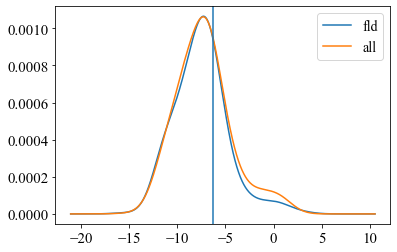

In [185]:
fld_no = 13
Lcoords = np.ones(10000)*pFields.fields[fld_no]['centre_l'] -pp.lshift
Bcoords = np.ones(10000)*pFields.fields[fld_no]['centre_b'] -pp.bshift
# print(Lcoords[0], Bcoords[0],pp.lrange, pp.brange)

xx = np.linspace(-100,50,10000)
Vcoords = np.vstack([xx,np.zeros(len(Lcoords))]).T

def find_bracket_indices(sorted_array, values):
    lower_indices = np.searchsorted(sorted_array, values, side='left')
    lower_indices[lower_indices == 0] += 1
    return lower_indices-1
    
gg=np.reshape([pp.pft[i](Vcoords) for i in range(len(pp.pft))], (*pp.lbgrid[0].shape,len(Vcoords)))
ll = find_bracket_indices(pp.lrange, Lcoords)
bb = find_bracket_indices(pp.brange, np.abs(Bcoords))
delta_l = (Lcoords - pp.lrange[ll])/(pp.lrange[ll+1]-pp.lrange[ll])
delta_b = (np.abs(Bcoords) - pp.brange[bb])/(pp.brange[bb+1]-pp.brange[bb])
ar = np.arange(len(Vcoords))
print(delta_l[0], delta_b[0], Lcoords[0], Bcoords[0], ll[0], bb[0])

inT = gg[ll,bb,ar]*(1-delta_l)*(1-delta_b) + gg[ll+1,bb,ar]*delta_l*(1-delta_b) + gg[ll,bb+1,ar]*(1-delta_l)*delta_b + gg[ll+1,bb+1,ar]*delta_l*delta_b

plt.plot(xx/4.74,pFields.fields[fld_no]['kde'](np.vstack([xx,np.zeros_like(xx)]).T),label='fld')

plt.plot(xx/4.74,inT,label='all')

plt.legend()
plt.axvline(-6.3)

In [2]:
import numpyro
import jax.numpy as jnp
from df_jax import binney_df_jax_spline
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline

def logL_numpyro(data, params, aux_params):

    bdf = binney_df_jax_spline(params['ln_Rdisk_coeffs'], params['ln_Hdisk_coeffs'], params['ln_sigmar0_coeffs'],
                               aux_knots=aux_params['aux_knots'], mass=1., vO=aux_params['vO'], 
                               Jv0=aux_params['Jv0'], Jd0=aux_params['Jd0'])

    num = jnp.logsumexp(jnp.log(bdf(data['num_actions'], data['num_log10P'])).reshape(aux_params['num_shape'])
                        -data['num_ln_weights'], axis=1)
    denom = jnp.logsumexp(jnp.log(bdf(data['denom_actions'], data['denom_log10P'])).reshape(aux_params['denom_shape'])
                          -data['denom_ln_weights'], axis=1)

    if aux_params['include_portail_weight']:
        ln_w_P = InterpolatedUnivariateSpline(aux_params['aux_knots'], aux_params['ln_w_P_coeffs'], k=3)
        num = np.logaddexp(num, ln_w_P(data['num_log10P']) + data['num_pFweights'])
        denom = np.logaddexp(denom, ln_w_P(data['denom_log10P']) + data['denom_pFweights'])

    return num-denom

aux_params = {'aux_knots':jnp.linspace(2.,3.,5), 'vO':140., 'Jv0':0., 'Jd0':0., 'num_shape':(100,100), 'denom_shape':(100,100),
              'include_portail_weight':True}
default_dist = numpyro.distributions.Normal(5.).expand([len(aux_params['aux_knots'])])
parameters = {'ln_Rdisk_coeffs': default_dist, 'ln_Hdisk_coeffs': default_dist, 'ln_sigmar0_coeffs': default_dist,
              'ln_wP_coeffs': default_dist}
data = {'num_pFweights':jnp.zeros(100), 'denom_pFweights':jnp.zeros(100)}

In [3]:
InterpolatedUnivariateSpline(jnp.linspace(2.,3.,6), jnp.ones(6), k=3)

2023-04-28 11:48:02.398044: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1207] Failed to get stream capture info: out of memory
2023-04-28 11:48:02.409974: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2432] Execution of replica 0 failed: INVALID_ARGUMENT: stream is uninitialized or in an error state


XlaRuntimeError: INVALID_ARGUMENT: stream is uninitialized or in an error state